In [2]:
# Importamos las librerías
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import re
import shutil
import string

from tensorflow.keras import layers
from tensorflow.keras import losses

In [3]:
# Imprimimos la versión de TensorFlow
print(tf.__version__)

2.12.0


Este cuaderno entrena un modelo de análisis de opiniones para clasificar las reseñas de películas como positivas o negativas, según el texto de la reseña. Este es un ejemplo de clasificación binaria — o de dos clases —, un tipo de problema de aprendizaje automático importante y ampliamente aplicable.

Utilizará el conjunto de datos de reseñas de películas grandes que contiene el texto de 50 000 reseñas de películas de la base de datos de películas de Internet. Estos se dividen en 25 000 revisiones para capacitación y 25 000 revisiones para pruebas. Los conjuntos de entrenamiento y prueba están equilibrados, lo que significa que contienen la misma cantidad de reseñas positivas y negativas.

In [4]:
# Url del conjunto de datos.
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

# Utilizamos tf.keras.utils.get_file para descargar y extraer el archivo tar.gz.
dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                  untar = True, cache_dir = '.',
                                  cache_subdir = '')

# Creamos la ruta al directorio del conjunto de datos extrayendo el directorio del archivo descargado.
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84125825/84125825 [==============================] - 106s 1us/step


In [5]:
# Listamos los contenidos del directorio del conjunto de datos.
os.listdir(dataset_dir)

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

In [6]:
# Creamos la ruta al directorio 'train' dentro del conjunto de datos y lista sus contenidos.
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsup',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

In [7]:
# Miremos un archivo de texto, que sería una reseña de una sola película
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [8]:
# Eliminamos las carpetas adicionales.
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [9]:
# Creamos un conjunto de validación haciendo una división 80:20 de los datos de entrenamiento.
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size = batch_size,
    validation_split = 0.2,
    subset = 'training',
    seed = seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [10]:
# Iteramos sobre el conjunto de datos e imprimimos algunos ejemplos.
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print('Review', text_batch.numpy()[i])
        print('Label', label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [11]:
# Usamos class_names para ver cuáles corresponden a reseñas positivas y negativas.
print('Label 0 corresponde a', raw_train_ds.class_names[0])
print('Label 1 corresponde a', raw_train_ds.class_names[1])

Label 0 corresponde a neg
Label 1 corresponde a pos


In [12]:
# Creamos un conjunto de validación y prueba.

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    validation_split = 0.2,
    subset = 'validation',
    seed = seed
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [13]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size = batch_size)

Found 25000 files belonging to 2 classes.


Vamos a estandarizar, tokenizar y vectorizar los datos utilizando tf.keras.layers.TextVectorization

La estandarización se refiere al preprocesamiento del texto, generalmente para eliminar la puntuación o elementos HTML para simplificar el conjunto de datos. La tokenización se refiere a dividir cadenas en tokens (por ejemplo, dividir una oración en palabras individuales, dividiéndola en espacios en blanco). La vectorización se refiere a convertir tokens en números para que puedan alimentar una red neuronal. Todas estas tareas se pueden lograr con esta capa.

In [15]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                    '[%s]' % re.escape(string.punctuation),
                                    '')

In [16]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens = max_features,
    output_mode = 'int',
    output_sequence_length = sequence_length)

In [17]:
''' Usamos adapt para ajustar el estado de la capa de preprocesamiento al conjunto de datos. Esto va a hacer 
que el modelo genere un índice de cadenas a números enteros. '''

train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [18]:
# Creamos una función para ver el resultado de usar esta capa para preprocesar algunos datos.
def vectorize_text(text, label):
    text = tf.expand_dims(text, - 1)
    return vectorize_layer(text), label

text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]

print('Review', first_review)
print('Label', raw_test_ds.class_names[first_label]),
print('Vectorized review', vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

In [19]:
# Busquemos algunos tokens con .get_vocabulary().
print('1287 ------> ', vectorize_layer.get_vocabulary()[1287])
print(' 313 ------> ', vectorize_layer.get_vocabulary()[313])
print('Vocabulart size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 ------>  silent
 313 ------>  night
Vocabulart size: 10000


In [20]:
''' Como paso final de preprocesamiento, vamos a aplicar la capa TextVectorization al conjunto de datos
de entrenamiento, validación y prueba. '''

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

Configuramos el conjunto de datos para el rendimiento.

Estos son metodos importantes que usar para asegurarse de que la E/S no se bloquee.

.cache() mantiene los datos en la memoria después de que se cargan fuera del disco. Esto asegurará que el conjunto de datos no se convierta en un cuello de botella mientras entrena su modelo. Si su conjunto de datos es demasiado grande para caber en la memoria, también puede usar este método para crear un caché en disco de alto rendimiento, que es más eficiente para leer que muchos archivos pequeños.

.prefetch() superpone el preprocesamiento de datos y la ejecución del modelo durante el entrenamiento.

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

### Modelo

In [22]:
# Dimensión de embedding para representar las palabras en el espacio vectorial.
embedding_dim = 16

# Creación de un modelo secuancial en Keras.
model = tf.keras.Sequential([
    # Capa de embedding para convertir números enteros en vectores de embedding.
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Dropout(0.2),
    # Capa de pooling global para reducir la dimensionalidad de las representaciones.
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    # Capa densa con una sola unidad, utilizada para la clasificación binaria.
    layers.Dense(1)  
])

# Muestra un resumen del modelo, que incluye la arquitectura y el número de parámetros.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

Un modelo necesita una función de pérdida y un optimizador para el entrenamiento. Dado que se trata de un problema de clasificación binaria y el modelo genera una probabilidad (una capa de una sola unidad con una activación sigmoidea), utilizará la función de pérdida losses.BinaryCrossentropy .

In [23]:
model.compile(
    # Función de pérdida para problemas de clasificación binaria con logits.
    loss = losses.BinaryCrossentropy(from_logits = True),
    optimizer = 'adam', # Ajusta los pesos del modelo durante el entrenamiento.
    # Métrica para evaluar la precisión binaria del modelo con umbral de decisión en 0.0.
    metrics = tf.metrics.BinaryAccuracy(threshold = 0.0))

In [24]:
#Entrenamos el modelo.
epochs = 10

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs
)

Epoch 1/10
625/625 [==============================] - 79s 124ms/step - loss: 0.6643 - binary_accuracy: 0.6940 - val_loss: 0.6151 - val_binary_accuracy: 0.7720
Epoch 2/10
625/625 [==============================] - 5s 9ms/step - loss: 0.5485 - binary_accuracy: 0.8008 - val_loss: 0.4982 - val_binary_accuracy: 0.8230
Epoch 3/10
625/625 [==============================] - 5s 9ms/step - loss: 0.4446 - binary_accuracy: 0.8456 - val_loss: 0.4200 - val_binary_accuracy: 0.8476
Epoch 4/10
625/625 [==============================] - 6s 10ms/step - loss: 0.3785 - binary_accuracy: 0.8678 - val_loss: 0.3736 - val_binary_accuracy: 0.8610
Epoch 5/10
625/625 [==============================] - 6s 10ms/step - loss: 0.3355 - binary_accuracy: 0.8781 - val_loss: 0.3448 - val_binary_accuracy: 0.8684
Epoch 6/10
625/625 [==============================] - 6s 10ms/step - loss: 0.3039 - binary_accuracy: 0.8893 - val_loss: 0.3257 - val_binary_accuracy: 0.8712
Epoch 7/10
625/625 [==============================] - 6s 1

In [26]:
# Evaluamos el modelo.
loss, accuracy = model.evaluate(test_ds)

print('Loss: ', loss)
print('Acurracy: ', accuracy)

782/782 [==============================] - 20s 26ms/step - loss: 0.2308 - binary_accuracy: 0.9148
Loss:  0.23077356815338135
Acurracy:  0.9148399829864502


### Creamos un gráfico de precisión y pérdida.

In [27]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

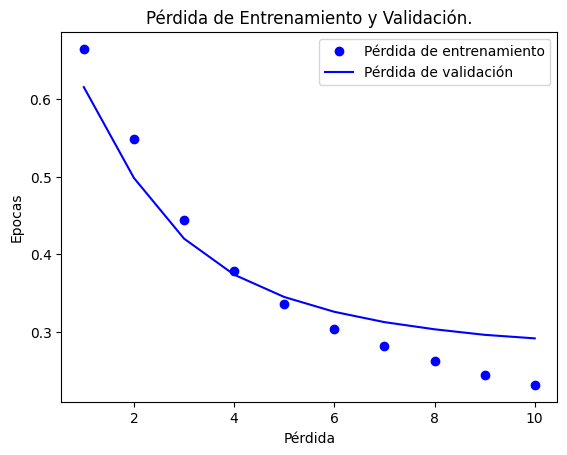

In [29]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label = 'Pérdida de entrenamiento') # "bo" es para "Blue dot" (punto azul).
plt.plot(epochs, val_loss, 'b', label = 'Pérdida de validación') # "b" es para "solid blue line".
plt.title('Pérdida de Entrenamiento y Validación.')
plt.ylabel('Epocas')
plt.xlabel('Pérdida')
plt.legend()

plt.show()

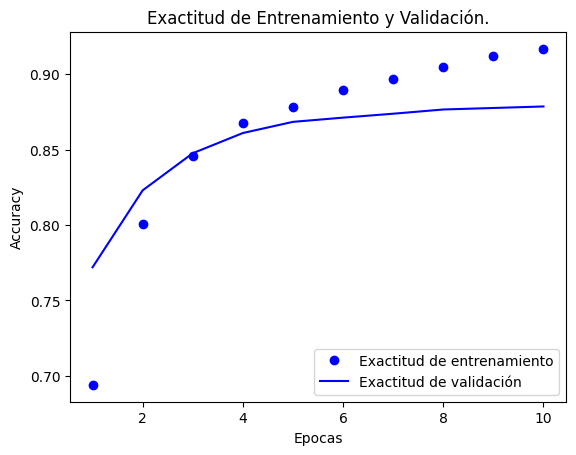

In [30]:
plt.plot(epochs, acc, 'bo', label = 'Exactitud de entrenamiento')
plt.plot(epochs, val_acc, 'b', label = 'Exactitud de validación')
plt.title('Exactitud de Entrenamiento y Validación.')
plt.xlabel('Epocas')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')

plt.show()